# Feasibility Studies for Smartwatch

We're interested in a few things, but I'll probably hash them out properly later

### Response Rate
How often a participant entered a "No response", per day of the study

In [32]:
"""
Find "No response" rate per user per day of the study

"""
import pandas as pd
import numpy as np
from typing import Union

from ema import clean

meal_info = clean.cleaned_smartwatch(remove_catchups=True)


def fraction(positive: pd.Series, negative: pd.Series, *, axis: int = 0) -> float:
    """
    Given two series of positive and negative responses, find the fraction of positive responses

    """
    return len(positive) / (len(positive) + len(negative))


def resample_without_replacement(positive, negative, num_samples):
    # Concatenate the arrays
    combined = np.concatenate((positive, negative))

    # Generate a mask for the positive array in the combined array
    positive_mask = np.array([True] * len(positive) + [False] * len(negative))

    # Sample without replacement
    indices = np.random.choice(len(combined), num_samples, replace=False)

    # Separate the resampled data back into positive and negative
    positive_resampled = combined[indices][positive_mask[indices]]
    negative_resampled = combined[indices][~positive_mask[indices]]

    return positive_resampled, negative_resampled


def fraction_per_day(meal_df: pd.DataFrame, label: Union[str, list]) -> tuple:
    """
    Get the fraction per day and its error for a specified type of meal_type

    """
    if isinstance(label, str):
        label = [label]

    all_labels = ["Meal", "Snack", "Drink", "No food/drink", "No response"]
    for l in label:
        assert l in all_labels, l

    # Iterate over days, slicing per day and finding the fraction of responses
    fractions, errors = [], []

    for day in range(1, 8):
        # Find how many positive and negative responses on each day
        mask = (meal_df["delta"] > pd.Timedelta(days=day)) & (
            meal_df["delta"] < pd.Timedelta(days=day + 1)
        )
        meals_on_this_day = meal_df[mask]
        positive = meals_on_this_day[meals_on_this_day["meal_type"].isin(label)]
        negative = meals_on_this_day[
            meals_on_this_day["meal_type"].isin(
                [l for l in all_labels if l not in label]
            )
        ]

        # Find the fraction of positive responses
        fractions.append(fraction(positive, negative))

        # Find its uncertainty by bootstrapping
        # Resample the array, take the fraction, and repeat
        # Find the standard deviation of the fractions
        # This is the error

    return np.array(fractions), np.array(errors)

(array([[184, 'No response', 'No response', ..., 0, 0,
        Timedelta('1 days 14:02:56')],
       [9, 'No response', 'No response', ..., 0, 0,
        Timedelta('1 days 11:06:53')],
       [394, 'No response', 'No response', ..., 0, 0,
        Timedelta('1 days 14:14:10')],
       ...,
       [187, 'No response', 'No response', ..., 1, 0,
        Timedelta('1 days 17:07:51')],
       [802, 'No response', 'No response', ..., 1, 0,
        Timedelta('1 days 16:04:48')],
       [296, 'No response', 'No response', ..., 0, 0,
        Timedelta('1 days 20:13:49')]], dtype=object), array([[805, 'No food/drink', 'No response', ..., 1, 0,
        Timedelta('1 days 19:06:21')],
       [17, 'Meal', 'Mid-size', ..., 0, 0, Timedelta('1 days 10:01:05')],
       [400, 'No food/drink', 'No response', ..., 0, 0,
        Timedelta('1 days 19:04:11')],
       ...,
       [948, 'Meal', 'Large', ..., 0, 0, Timedelta('1 days 10:16:46')],
       [317, 'Drink', 'Large', ..., 0, 0, Timedelta('1 days 19:18:3

AssertionError: 

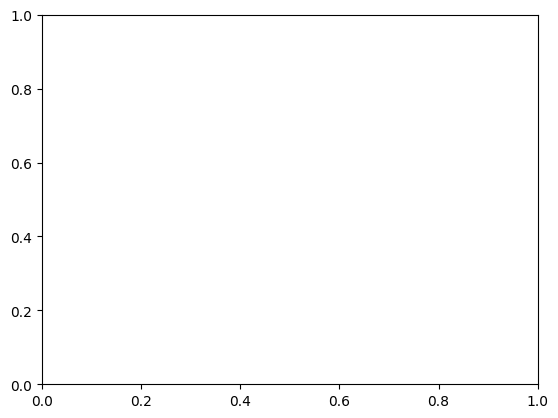

In [33]:
"""
Plot them

"""
import matplotlib.pyplot as plt


def plot(
    axis: plt.Axes, fractions: np.ndarray, errs: np.ndarray, x_ticks, **plot_kw
) -> None:
    """
    Plot the specified fractions and errors on the provided axis

    """
    axis.errorbar(
        x_ticks,
        100 * fractions,
        yerr=100 * errs,
        fmt="-o",
        **plot_kw,
    )


fig, axis = plt.subplots()

plot(
    axis,
    *fraction_per_day(meal_info, "No response"),
    np.arange(1, 8) - 0.1,
    label="No response",
    color="r",
)
plot(
    axis,
    *fraction_per_day(meal_info, ["Meal", "Drink", "Snack", "No food/drink"]),
    np.arange(1, 8),
    label="Meal/Drink/Snack/Nothing",
    color="g",
)

axis.set_xticklabels([f"Day {i}" for i in range(8)])

axis.set_ylim(0, 100)
axis.set_title("Response Type per Day")
axis.set_ylabel("%")
axis.legend()

fig.tight_layout()
fig.savefig("img/response_types.png")

/tmp/ipykernel_5452/1922352142.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f"Day {i}" for i in range(8)])


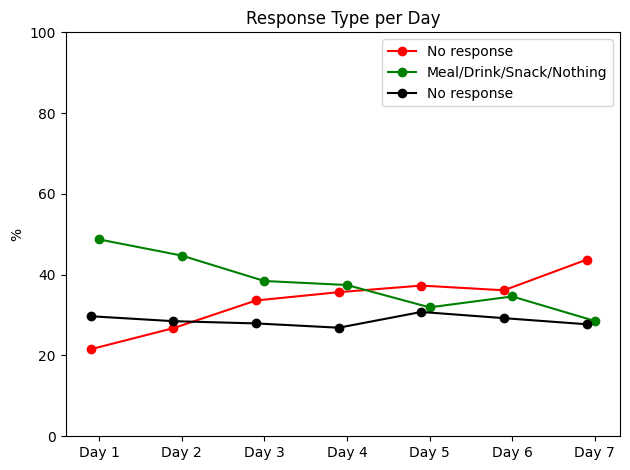

In [7]:
fig, axis = plt.subplots()

plot(
    axis,
    *fraction_per_day(meal_info, "No response"),
    np.arange(1, 8) - 0.1,
    label="No response",
    color="r",
)
plot(
    axis,
    *fraction_per_day(meal_info, ["Meal", "Drink", "Snack"]),
    np.arange(1, 8),
    label="Meal/Drink/Snack/Nothing",
    color="g",
)
plot(
    axis,
    *fraction_per_day(meal_info, "No food/drink"),
    np.arange(1, 8) - 0.1,
    label="No response",
    color="k",
)

axis.set_xticklabels([f"Day {i}" for i in range(8)])

axis.set_ylim(0, 100)
axis.set_title("Response Type per Day")
axis.set_ylabel("%")
axis.legend()

fig.tight_layout()
fig.savefig("img/three_response_types.png")

/tmp/ipykernel_5452/4036846043.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f"Day {i}" for i in range(8)])


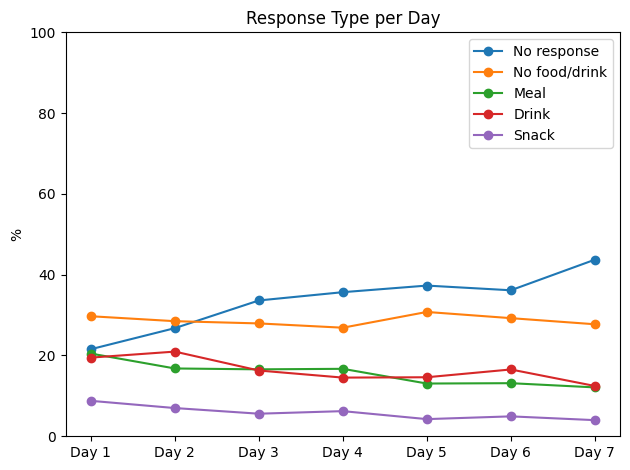

In [8]:
fig, axis = plt.subplots()

for label, colour in zip(
    ["No response", "No food/drink", "Meal", "Drink", "Snack"],
    ["r", "k", "b", "g", "o"],
):
    plot(
        axis,
        *fraction_per_day(meal_info, label),
        np.arange(1, 8),
        label=label,
    )

axis.set_xticklabels([f"Day {i}" for i in range(8)])

axis.set_ylim(0, 100)
axis.set_title("Response Type per Day")
axis.set_ylabel("%")
axis.legend()

fig.tight_layout()
fig.savefig("img/all_response_types.png")